In [1]:
# population analysis

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

In [30]:
df = pd.read_hdf('/home/niell_lab/Niell-V2-W7/T/freely_moving_ephys/batch_files/061821/updated_ephys_props.h5')

In [4]:
list(df.columns.values)

['index',
 'Amplitude',
 'ContamPct',
 'KSLabel',
 'amp',
 'ch',
 'depth',
 'fr',
 'group',
 'fm1_n_spikes',
 'sh',
 'waveform',
 'fm1_spikeT',
 't0',
 'fm1_spikeTraw',
 'fm1_rate',
 'fm1_c_range',
 'fm1_crf_cent',
 'fm1_crf_tuning',
 'fm1_crf_err',
 'fm1_spike_triggered_average',
 'fm1_sta_shape',
 'fm1_spike_triggered_variance',
 'fm1_upsacc_avg',
 'fm1_downsacc_avg',
 'fm1_upsacc_avg_gaze_shift_dEye',
 'fm1_downsacc_avg_gaze_shift_dEye',
 'fm1_upsacc_avg_comp_dEye',
 'fm1_downsacc_avg_comp_dEye',
 'fm1_upsacc_avg_gaze_shift_dHead',
 'fm1_downsacc_avg_gaze_shift_dHead',
 'fm1_upsacc_avg_comp_dHead',
 'fm1_downsacc_avg_comp_dHead',
 'fm1_spike_rate_vs_pupil_radius_cent',
 'fm1_spike_rate_vs_pupil_radius_tuning',
 'fm1_spike_rate_vs_pupil_radius_err',
 'fm1_spike_rate_vs_theta_cent',
 'fm1_spike_rate_vs_theta_tuning',
 'fm1_spike_rate_vs_theta_err',
 'fm1_spike_rate_vs_gz_cent',
 'fm1_spike_rate_vs_gz_tuning',
 'fm1_spike_rate_vs_gz_err',
 'fm1_spike_rate_vs_gx_cent',
 'fm1_spike_rate_

In [22]:
th_pos = data['fm1_wn_spike_rate_vs_theta_modind_pos']
th_neg = data['fm1_wn_spike_rate_vs_theta_modind_neg']
pitch_pos = data['fm1_wn_spike_rate_vs_pitch_modind_pos']
pitch_neg = data['fm1_wn_spike_rate_vs_pitch_modind_neg']

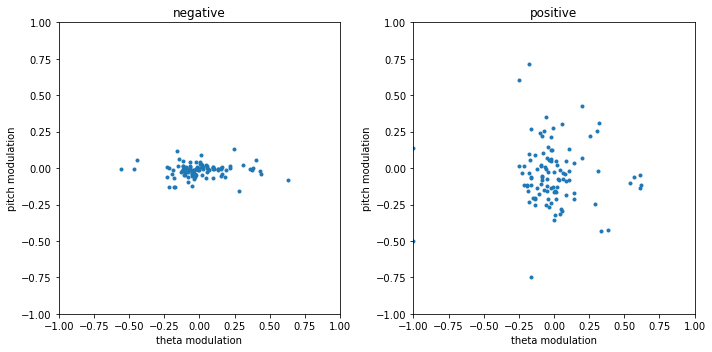

In [28]:
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(th_neg, pitch_neg, '.')
plt.ylim([-1,1]); plt.xlim([-1,1])
# plt.plot([-1,1],[-1,1],'r:')
plt.title('negative')
plt.xlabel('theta modulation'); plt.ylabel('pitch modulation')
plt.subplot(1,2,2)
plt.plot(th_pos, pitch_pos, '.')
plt.ylim([-1,1]); plt.xlim([-1,1])
# plt.plot([-1,1],[-1,1],'r:')
plt.title('positive')
plt.xlabel('theta modulation'); plt.ylabel('pitch modulation')
plt.tight_layout()

Text(0, 0.5, 'dHeadmodulation')

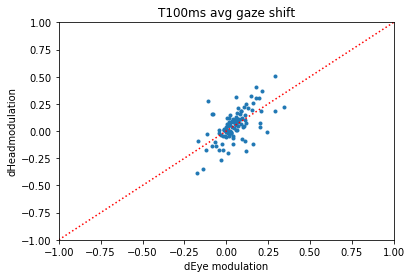

In [20]:
plt.plot(dEyeT100_modind, dHeadT100_modind, '.')
plt.ylim([-1,1]); plt.xlim([-1,1])
plt.plot([-1,1],[-1,1],'r:')
plt.title('T100ms avg gaze shift')
plt.xlabel('dEye modulation'); plt.ylabel('dHeadmodulation')

In [ ]:
dEyeT0_modind_comp = data['fm1_upsacc_comp_dEye_modind_t0']
dEyeT100_modind_comp = data['fm1_upsacc_comp_dEye_modind_t100']
dHeadT0_modind_comp = data['fm1_upsacc_comp_dHead_modind_t0']
dHeadT100_modind_comp = data['fm1_upsacc_comp_dHead_modind_t100']

In [ ]:
plt.plot(dEyeT0_modind_comp, dHeadT0_modind_comp, '.')
plt.ylim([-1,1]); plt.xlim([-1,1])
plt.plot([-1,1],[-1,1],'r:')
plt.xlabel('dEye gaze shift right modulation'); plt.ylabel('dHead gaze shift right modulation')

Text(0.5, 0, 'channels above or below center of layer 4')

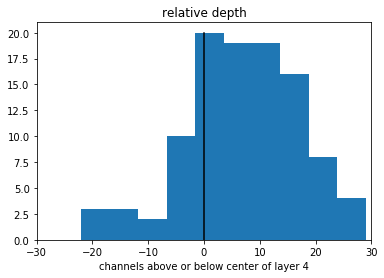

In [37]:
plt.hist(df['hf4_revchecker_ch_lfp_relative_depth'])
plt.title('relative depth')
plt.xlim([-30,30])
plt.plot([0,0],[0,20],'k')
plt.xlabel('channels above or below center of layer 4')

Text(0.5, 1.0, 'orientation selectivity vs depth')

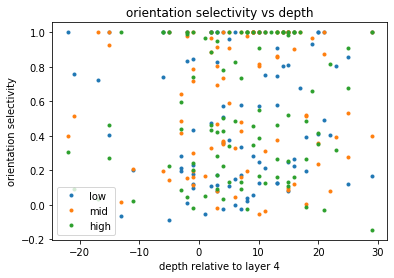

In [40]:
plt.plot(df['hf4_revchecker_ch_lfp_relative_depth'], df['hf3_gratings_osi_low'], '.')
plt.plot(df['hf4_revchecker_ch_lfp_relative_depth'], df['hf3_gratings_osi_mid'], '.')
plt.plot(df['hf4_revchecker_ch_lfp_relative_depth'], df['hf3_gratings_osi_high'], '.')
plt.legend(['low','mid','high'])
plt.ylabel('orientation selectivity'); plt.xlabel('depth relative to layer 4')
plt.title('orientation selectivity vs depth')

Text(0.5, 0, 'orientation selectivity')

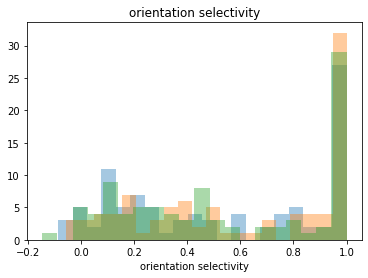

In [44]:
plt.hist(df['hf3_gratings_osi_low'], alpha=0.4, bins=20)
plt.hist(df['hf3_gratings_osi_mid'], alpha=0.4, bins=20)
plt.hist(df['hf3_gratings_osi_high'], alpha=0.4, bins=20)
plt.title('orientation selectivity')
plt.xlabel('orientation selectivity')

/home/niell_lab/anaconda3/envs/DLC-GPU2/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Text(0.5, 1.0, 'R=-0.247 p=0.011')

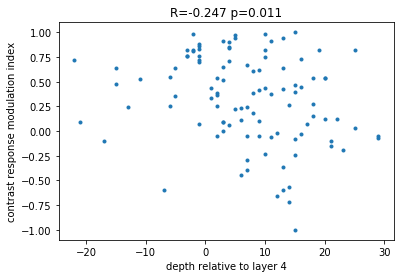

In [65]:
plt.plot(df['hf4_revchecker_ch_lfp_relative_depth'], df['hf1_wn_crf_modind'], '.')
plt.ylabel('contrast response modulation index'); plt.xlabel('depth relative to layer 4')
good = ~np.isnan(df['hf4_revchecker_ch_lfp_relative_depth']) * ~np.isnan(df['hf1_wn_crf_modind'])
depth = df['hf4_revchecker_ch_lfp_relative_depth'][good]
crfmi = df['hf1_wn_crf_modind'][good]
corr = scipy.stats.pearsonr(depth,crfmi)
plt.title('R='+str(np.round(corr[0],3))+' p='+str(np.round(corr[1],3)))

In [47]:
cols = df.columns.values

In [52]:
np.argmax([cols=='unit'])

452

In [54]:
len(cols) - 453

47

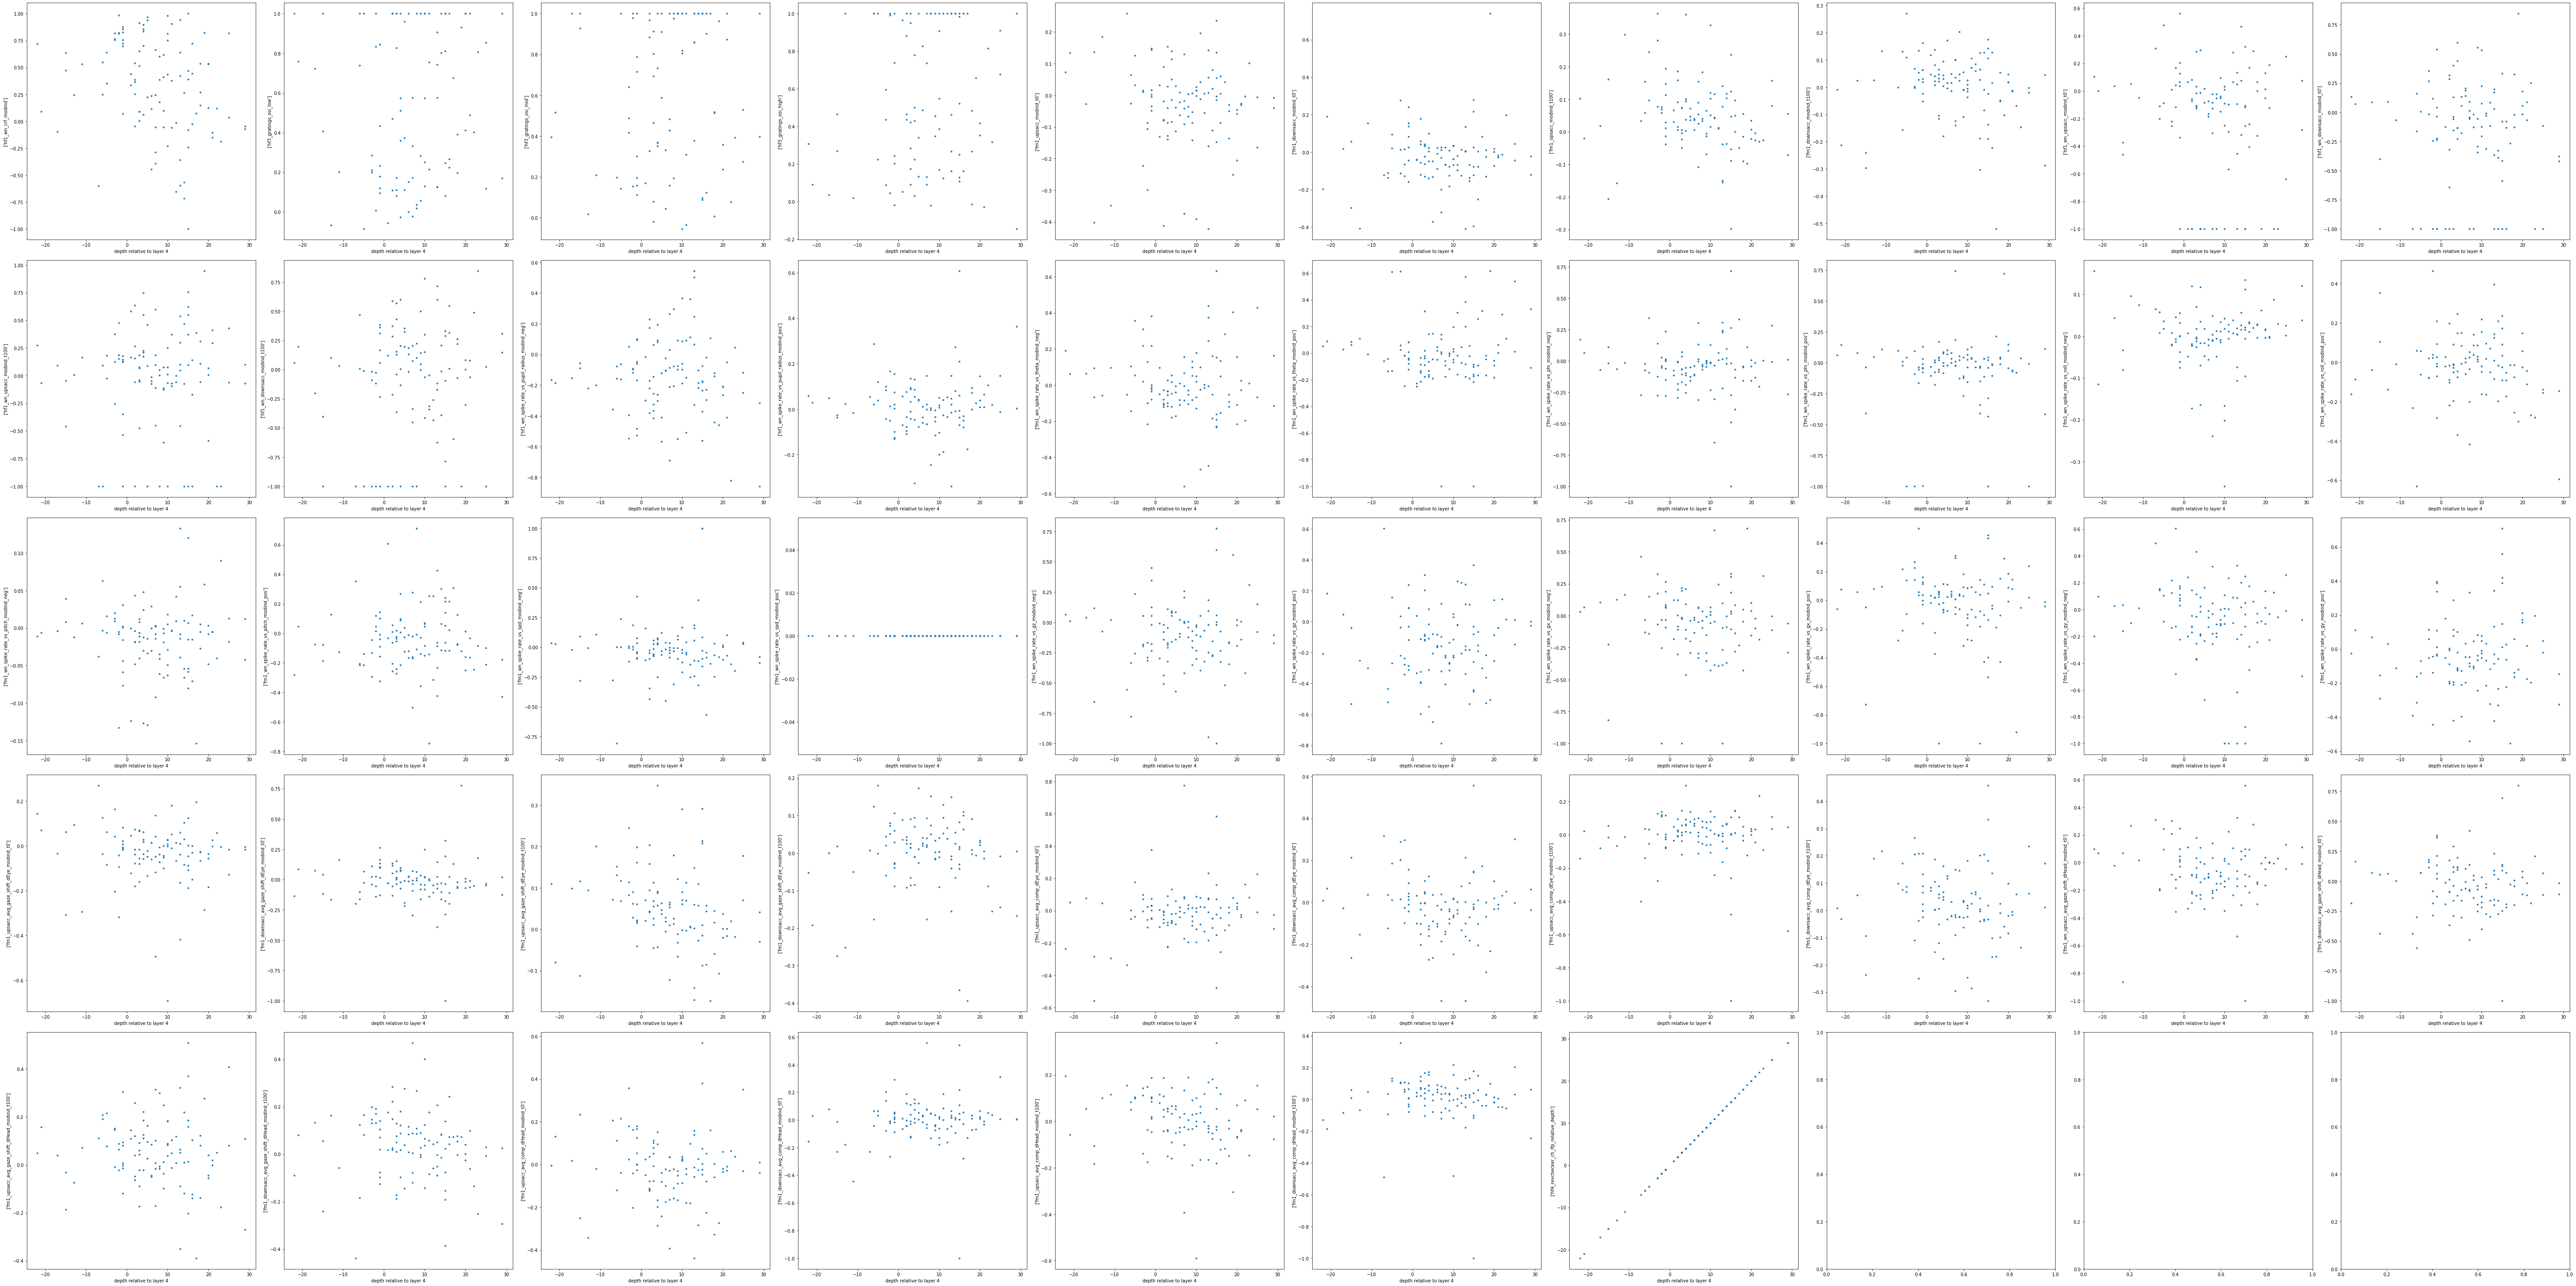

In [59]:
plt.subplots(5,10,figsize=(80,40))
i = 0
for col in cols[453:]:
    plt.subplot(5,10,i+1)
    plt.plot(df['hf4_revchecker_ch_lfp_relative_depth'], df[col], '.')
    plt.ylabel([col]); plt.xlabel('depth relative to layer 4')
    i = i + 1
plt.tight_layout()
plt.show()

In [69]:
type(df['fm1_dEye'][0]) == scipy.interpolate.interpolate.interp1d

True

In [68]:
df['fm1_dEye'][0]